In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [3]:
df = pd.read_csv('..\data_final\dataset_without_outliers.csv', index_col=0)
df1 = pd.read_csv('..\data_final\dataset_with_outliers.csv', index_col=0)

In [4]:
def prepare(df):
    df['casting_score_mean'] = df['casting_score_mean'].map(int)
    df.drop(columns = ['titre', 'realisateur', 'casting', 'compagnies_production', 
        'recette', 'director_score_mean', 'director_score_med',
        'director_score_min', 'director_score_max',
        'compagnies_score_mean', 'compagnies_score_med', 'compagnies_score_min',
        'compagnies_score_max'], inplace = True)
    return df

prepare(df)
prepare(df1)

,budget,duree,suite,Comedy,Drama,Horror,Thriller,Action,Adventure,Science Fiction,...,TV Movie,saison,benefice global,casting_score_sum,casting_score_mean,casting_score_med,casting_score_min,casting_score_max,director_score_sum,compagnies_score_sum
0,40000000,110,3,1,0,0,0,0,0,0,...,0,2,324.592525,79,1,0,0,38,27,135
1,2000000,100,1,1,1,0,0,0,0,0,...,0,2,-88.000000,0,0,0,0,0,0,0
2,170000000,136,2,0,0,0,0,1,1,1,...,0,0,320.450925,459,7,0,0,100,128,81
3,4000000,80,1,1,0,0,0,0,0,0,...,0,3,148.456700,0,0,0,0,0,0,0
4,12000000,95,1,0,1,0,0,0,1,0,...,0,0,-92.608333,5,0,0,0,5,4,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7851,10000,91,1,0,1,0,0,0,0,0,...,0,1,0.000000,0,0,0,0,0,0,0
7852,300,0,1,0,1,0,0,0,0,0,...,0,1,-99.666667,0,0,0,0,0,0,0
7853,16000,70,1,0,1,0,1,0,0,0,...,0,3,25.000000,0,0,0,0,0,0,0
7854,75,75,1,0,0,0,0,0,0,0,...,0,0,0.000000,0,0,0,0,0,0,0


### Librairies pour la prédiction

In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from random import shuffle
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, StratifiedKFold, RandomizedSearchCV

In [6]:
def construction_tranche(df):
    df['tranche benef'] = 0
    df.loc[df['benefice global'] >= df['benefice global'].quantile(0.25), 'tranche benef'] = 1
    df.loc[df['benefice global'] >= df['benefice global'].quantile(0.5), 'tranche benef'] = 2
    df.loc[df['benefice global'] >= df['benefice global'].quantile(0.75), 'tranche benef'] = 3
    df['tranche benef binaire'] = 0
    df.loc[df['benefice global'] > 0, 'tranche benef binaire'] = 1
    df['tranche benef binaire'].value_counts()
    return df

construction_tranche(df)
construction_tranche(df1)

,budget,duree,suite,Comedy,Drama,Horror,Thriller,Action,Adventure,Science Fiction,...,benefice global,casting_score_sum,casting_score_mean,casting_score_med,casting_score_min,casting_score_max,director_score_sum,compagnies_score_sum,tranche benef,tranche benef binaire
0,40000000,110,3,1,0,0,0,0,0,0,...,324.592525,79,1,0,0,38,27,135,2,1
1,2000000,100,1,1,1,0,0,0,0,0,...,-88.000000,0,0,0,0,0,0,0,0,0
2,170000000,136,2,0,0,0,0,1,1,1,...,320.450925,459,7,0,0,100,128,81,2,1
3,4000000,80,1,1,0,0,0,0,0,0,...,148.456700,0,0,0,0,0,0,0,2,1
4,12000000,95,1,0,1,0,0,0,1,0,...,-92.608333,5,0,0,0,5,4,54,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7851,10000,91,1,0,1,0,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,1,0
7852,300,0,1,0,1,0,0,0,0,0,...,-99.666667,0,0,0,0,0,0,0,0,0
7853,16000,70,1,0,1,0,1,0,0,0,...,25.000000,0,0,0,0,0,0,0,1,1
7854,75,75,1,0,0,0,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,1,0


<AxesSubplot: xlabel='tranche benef binaire', ylabel='Count'>

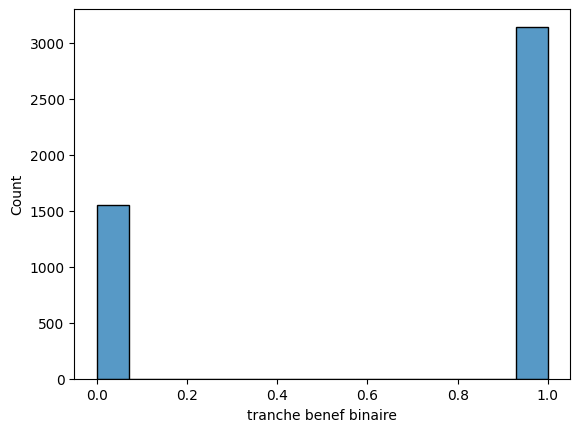

In [7]:
sns.histplot(data=df, x="tranche benef binaire")

In [8]:
def X_and_Y(df):
    X = df.drop(columns = ['tranche benef', 'benefice global', 'tranche benef binaire'])
    Y = df['tranche benef']
    Y_bin = df['tranche benef binaire']
    return X, Y, Y_bin

In [9]:
def train_test(df):
    X, Y, Y_bin = X_and_Y(df)
    TRAINING_SET_RATIO = 0.9    
    ind = [i for i in range(df.shape[0])]
    random.seed(4)
    random.shuffle(ind)
    X_train=X.iloc[ind[:int(TRAINING_SET_RATIO*df.shape[0])]]
    Y_train=Y.iloc[ind[:int(TRAINING_SET_RATIO*df.shape[0])]]
    Y_bin_train=Y_bin.iloc[ind[:int(TRAINING_SET_RATIO*df.shape[0])]]
    X_test=X.iloc[ind[int(TRAINING_SET_RATIO*df.shape[0]):]]
    Y_test=Y.iloc[ind[int(TRAINING_SET_RATIO*df.shape[0]):]]
    Y_bin_test=Y_bin.iloc[ind[int(TRAINING_SET_RATIO*df.shape[0]):]]

    Y_train_0 = Y_bin_train[Y_bin_train == 0]
    X_train_0 = X_train[Y_bin_train == 0]

    X_train_double = pd.concat([X_train, X_train_0], ignore_index=True)

    Y_train_double = pd.concat([Y_bin_train, Y_train_0], ignore_index=True)

    X_train_double['Y'] = Y_train_double

    X_train_double = X_train_double.iloc[np.random.permutation(X_train_double.index)].reset_index(drop=True)

    Y_train_double = X_train_double['Y']

    X_train_double.drop(['Y'], axis =1, inplace = True)

    TRAINING_SET_RATIO = 0.9    
    ind = [i for i in range(df.shape[0])]
    random.seed(4)
    random.shuffle(ind)

    X_train_val = X_train_double.iloc[ind[:int(TRAINING_SET_RATIO*X_train_double.shape[0])]]
    Y_train_val = Y_train_double.iloc[ind[:int(TRAINING_SET_RATIO*X_train_double.shape[0])]]
    X_val= X_train_double.iloc[ind[:int(TRAINING_SET_RATIO*df.shape[0])]]
    Y_val = Y_train_double.iloc[ind[int(TRAINING_SET_RATIO*df.shape[0]):]]

    return X_train, X_train_double, Y_train, Y_bin_train, Y_train_double, X_test, Y_test, Y_bin_test, X_train_val, Y_train_val, X_val, Y_val

In [10]:
def Random_search_XGBoost(df):
        X_train, X_train_double, Y_train, Y_bin_train, Y_train_double, X_test, Y_test, Y_bin_test, X_train_val, Y_train_val, X_val, Y_val = train_test(df)
        # A parameter grid for XGBoost
        params = {
                'min_child_weight': [1, 5, 10],
                'gamma': [0.5, 1, 1.5, 2, 5],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0],
                'max_depth': [3, 4, 5]
                }

        xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', silent=True, nthread=1)

        folds = 10
        param_comb = 5

        skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

        random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,Y_bin_train), verbose=3, random_state=1001 )

        random_search.fit(X_train, Y_bin_train)

        return random_search

def print_Random_search_XGBoost(df):
        random_search = Random_search_XGBoost(df)
        folds = 3
        param_comb = 5
        print('\n Best estimator:')
        print(random_search.best_estimator_)
        print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
        print(random_search.best_score_ * 2 - 1)
        print('\n Best hyperparameters:')
        print(random_search.best_params_)
        
        return random_search.best_estimator_

In [11]:
print_Random_search_XGBoost(df)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[14:02:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.


 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=600, n_jobs=1, nthread=1,
              num_parallel_tree=1, predictor='auto', ...)

 Best normalized gin

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=600, n_jobs=1, nthread=1,
              num_parallel_tree=1, predictor='auto', ...)

In [12]:
from sklearn.metrics import  make_scorer
def my_custom_loss_func(y_true, y_pred):
    C = confusion_matrix(y_true, y_pred, labels=[0,1])
    recall = C[0][0]/(C[0][0]+C[0][1])
    return recall

In [13]:
def scores_XGBoost(df):
    X_train, X_train_double, Y_train, Y_bin_train, Y_train_double, X_test, Y_test, Y_bin_test, X_train_val, Y_train_val, X_val, Y_val = train_test(df)
    xgb = XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=5,
              monotone_constraints='()', n_estimators=600, n_jobs=1, nthread=1,
              num_parallel_tree=1, predictor='auto')
    xgb.fit(X_train, Y_bin_train)
    Y_pred_test = xgb.predict(X_test)
    print(confusion_matrix(Y_bin_test, Y_pred_test, labels=[0,1]))
    print(classification_report(Y_bin_test, Y_pred_test, digits = 4))
    scores = cross_val_score(xgb, X_train, Y_bin_train, cv = 10, scoring='accuracy')

    print('Cross-validation scores:{}'.format(scores))
    print('Average cross-validation score: {:.4f}'.format(scores.mean()))
    print('Std cross-validation score: {:.4f}'.format(scores.std()))

    score = make_scorer(my_custom_loss_func, greater_is_better=True)
    scores = cross_val_score(xgb, X_train, Y_bin_train, cv = 10, scoring = score)

    print('Cross-validation scores:{}'.format(scores))
    print('Average cross-validation score: {:.4f}'.format(scores.mean()))
    print('Std cross-validation score: {:.4f}'.format(scores.std()))

In [14]:
scores_XGBoost(df)

[[ 43 107]
 [ 35 285]]
              precision    recall  f1-score   support

           0     0.5513    0.2867    0.3772       150
           1     0.7270    0.8906    0.8006       320

    accuracy                         0.6979       470
   macro avg     0.6392    0.5886    0.5889       470
weighted avg     0.6709    0.6979    0.6654       470

Cross-validation scores:[0.68794326 0.69739953 0.74468085 0.70685579 0.70212766 0.74170616
 0.6943128  0.69668246 0.74170616 0.67772512]
Average cross-validation score: 0.7091
Std cross-validation score: 0.0232
Cross-validation scores:[0.29787234 0.30496454 0.39007092 0.33333333 0.35       0.37142857
 0.25       0.33571429 0.36428571 0.30714286]
Average cross-validation score: 0.3305
Std cross-validation score: 0.0394


In [15]:
def Random_search_XGBoost_double(df):
        X_train, X_train_double, Y_train, Y_bin_train, Y_train_double, X_test, Y_test, Y_bin_test, X_train_val, Y_train_val, X_val, Y_val = train_test(df)
        # A parameter grid for XGBoost
        params = {
                'min_child_weight': [1, 5, 10],
                'gamma': [0.5, 1, 1.5, 2, 5],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0],
                'max_depth': [3, 4, 5]
                }

        xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic')

        folds = 3
        param_comb = 5

        skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

        random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train_double,Y_train_double), verbose=3, random_state=1001 )

        random_search.fit(X_train_double, Y_train_double)

        return random_search

def print_Random_search_XGBoost_double(df):
        random_search = Random_search_XGBoost_double(df)
        folds = 3
        param_comb = 5
        print('\n Best estimator:')
        print(random_search.best_estimator_)
        print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
        print(random_search.best_score_ * 2 - 1)
        print('\n Best hyperparameters:')
        print(random_search.best_params_)
        
        return random_search.best_estimator_

In [16]:
print_Random_search_XGBoost_double(df)

Fitting 3 folds for each of 5 candidates, totalling 15 fits

 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=600, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

 Best normalized gini score for 3-fold search with 5 parameter combinations:
0.5807884723445351

 Best hyperparameters:
{'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 1.5, 'colsample_bytree'

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=600, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [17]:
def scores_XGBoost_double(df):
    X_train, X_train_double, Y_train, Y_bin_train, Y_train_double, X_test, Y_test, Y_bin_test, X_train_val, Y_train_val, X_val, Y_val = train_test(df)
    xgb = XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, 
              monotone_constraints='()', n_estimators=600, n_jobs=1, nthread=1,
              num_parallel_tree=1, predictor='auto')
    xgb.fit(X_train_double, Y_train_double)
    Y_pred_test = xgb.predict(X_test)
    print(confusion_matrix(Y_bin_test, Y_pred_test, labels=[0,1]))
    print(classification_report(Y_bin_test, Y_pred_test, digits = 4))

In [18]:
scores_XGBoost_double(df)

[[ 79  71]
 [103 217]]
              precision    recall  f1-score   support

           0     0.4341    0.5267    0.4759       150
           1     0.7535    0.6781    0.7138       320

    accuracy                         0.6298       470
   macro avg     0.5938    0.6024    0.5949       470
weighted avg     0.6515    0.6298    0.6379       470



In [19]:
def Grid_search_Random_Forest_bin(df):
    X_train, X_train_double, Y_train, Y_bin_train, Y_train_double, X_test, Y_test, Y_bin_test, X_train_val, Y_train_val, X_val, Y_val = train_test(df)
    n_estimators = [100]
    max_features = ['auto']
    max_depth = [2, 3, 5]
    max_depth.append(None)
    min_samples_split = [2, 5]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True]

    params_grid = {'n_estimators': n_estimators, 'max_features': max_features,
                'max_depth': max_depth, 'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

    rf_clf = RandomForestClassifier(random_state=42)

    rf_cv = GridSearchCV(rf_clf, params_grid, scoring="accuracy", cv=10)

    rf_cv.fit(X_train, Y_bin_train)

    return rf_cv

def print_Grid_search_Random_Forest_bin(df):

    grid_search = Grid_search_Random_Forest_bin(df)
    # best score achieved during the GridSearchCV
    print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))

    # print parameters that give the best results
    print('Parameters that give the best results :','\n\n', (grid_search.best_params_))

    # print estimator that was chosen by the GridSearch
    print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))


    

In [20]:
print_Grid_search_Random_Forest_bin(df)

c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=

GridSearch CV best score : 0.7077


Parameters that give the best results : 

 {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


Estimator that was chosen by the search : 

 RandomForestClassifier(max_features='auto', min_samples_leaf=4, random_state=42)


In [21]:
Grid_search_Random_Forest_bin(df1)

c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [True], 'max_depth': [2, 3, 5, None],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5], 'n_estimators': [100]},
             scoring='accuracy')

In [24]:
def Grid_search_Random_Forest(df):
    X_train, X_train_double, Y_train, Y_bin_train, Y_train_double, X_test, Y_test, Y_bin_test, X_train_val, Y_train_val, X_val, Y_val = train_test(df)
    n_estimators = [100]
    max_features = ['auto']
    max_depth = [2, 3, 5]
    max_depth.append(None)
    min_samples_split = [2, 5]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True]

    params_grid = {'n_estimators': n_estimators, 'max_features': max_features,
                'max_depth': max_depth, 'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

    rf_clf = RandomForestClassifier(random_state=42)

    rf_cv = GridSearchCV(rf_clf, params_grid, scoring="accuracy", cv=3, verbose=2, n_jobs=-1)


    rf_cv.fit(X_train, Y_train)
    return rf_cv

def print_Grid_search_Random_Forest(df):

    grid_search = Grid_search_Random_Forest(df)
    # best score achieved during the GridSearchCV
    print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))

    # print parameters that give the best results
    print('Parameters that give the best results :','\n\n', (grid_search.best_params_))

    # print estimator that was chosen by the GridSearch
    print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))

In [26]:
print_Grid_search_Random_Forest(df)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearch CV best score : 0.3912


Parameters that give the best results : 

 {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


Estimator that was chosen by the search : 

 RandomForestClassifier(max_features='auto', min_samples_leaf=4, random_state=42)


In [29]:
def Random_Forest(df):
    X_train, X_train_double, Y_train, Y_bin_train, Y_train_double, X_test, Y_test, Y_bin_test, X_train_val, Y_train_val, X_val, Y_val = train_test(df)
    clf = RandomForestClassifier(max_features='auto', min_samples_leaf=4, random_state=42)
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    print(confusion_matrix(Y_test, Y_pred, labels=[0,1,2,3]))
    print(classification_report(Y_test, Y_pred, digits=4))

In [30]:
Random_Forest(df)

c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[[59 20 22 16]
 [33 20 27 34]
 [29 20 36 31]
 [23 10 32 58]]
              precision    recall  f1-score   support

           0     0.4097    0.5043    0.4521       117
           1     0.2857    0.1754    0.2174       114
           2     0.3077    0.3103    0.3090       116
           3     0.4173    0.4715    0.4427       123

    accuracy                         0.3681       470
   macro avg     0.3551    0.3654    0.3553       470
weighted avg     0.3564    0.3681    0.3574       470



In [ ]:
def Grid_search_Random_Forest_double(df):
    X_train, X_train_double, Y_train, Y_bin_train, Y_train_double, X_test, Y_test, Y_bin_test, X_train_val, Y_train_val, X_val, Y_val = train_test(df)
    n_estimators = [100]
    max_features = ['auto']
    max_depth = [k for k in range(15)] + [None]
    min_samples_split = [k for k in range(5)]
    min_samples_leaf = [k for k in range(5)]
    bootstrap = [True]

    params_grid = {'n_estimators': n_estimators, 'max_features': max_features,
                'max_depth': max_depth, 'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

    rf_clf = RandomForestClassifier(random_state=42)

    rf_cv = GridSearchCV(rf_clf, params_grid, scoring="accuracy", cv=10, verbose=2, n_jobs=-1)


    rf_cv.fit(X_train_double, Y_train_double)
    
    return rf_cv

def print_Grid_search_Random_Forest_double(df):

    grid_search = Grid_search_Random_Forest_double(df)
    # best score achieved during the GridSearchCV
    print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))

    # print parameters that give the best results
    print('Parameters that give the best results :','\n\n', (grid_search.best_params_))

    # print estimator that was chosen by the GridSearch
    print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))

    

In [ ]:
print_Grid_search_Random_Forest_double(df)

Fitting 10 folds for each of 400 candidates, totalling 4000 fits


c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
2200 fits failed out of a total of 4000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\joblib\parallel.py", line 1085, in __call_

GridSearch CV best score : 0.8623


Parameters that give the best results : 

 {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}


Estimator that was chosen by the search : 

 RandomForestClassifier(max_features='auto', min_samples_split=3,
                       random_state=42)


In [ ]:
def Random_Forest_double(df):
    X_train, X_train_double, Y_train, Y_bin_train, Y_train_double, X_test, Y_test, Y_bin_test, X_train_val, Y_train_val, X_val, Y_val = train_test(df)
    clf = RandomForestClassifier(max_features='auto', min_samples_split=3,
                       random_state=42)
    clf.fit(X_train_double, Y_train_double)
    Y_pred = clf.predict(X_test)
    print(confusion_matrix(Y_bin_test, Y_pred, labels=[0,1]))
    print(classification_report(Y_bin_test, Y_pred, digits=4))

In [ ]:
Random_Forest_double(df)

c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[[ 64  86]
 [ 70 250]]
              precision    recall  f1-score   support

           0     0.4776    0.4267    0.4507       150
           1     0.7440    0.7812    0.7622       320

    accuracy                         0.6681       470
   macro avg     0.6108    0.6040    0.6064       470
weighted avg     0.6590    0.6681    0.6628       470



In [ ]:
scores_XGBoost(df)

[[ 79  71]
 [103 217]]
              precision    recall  f1-score   support

           0     0.4341    0.5267    0.4759       150
           1     0.7535    0.6781    0.7138       320

    accuracy                         0.6298       470
   macro avg     0.5938    0.6024    0.5949       470
weighted avg     0.6515    0.6298    0.6379       470



In [ ]:
scores_XGBoost_double(df)

[[ 79  71]
 [103 217]]
              precision    recall  f1-score   support

           0     0.4341    0.5267    0.4759       150
           1     0.7535    0.6781    0.7138       320

    accuracy                         0.6298       470
   macro avg     0.5938    0.6024    0.5949       470
weighted avg     0.6515    0.6298    0.6379       470

